## Similarity Based Recommendation System (Collabarative Filtering - Food Recommendation )

#### Kaggle Data Set

Choosing what to eat at a restaurant can be hard. There are so many options! But imagine if the restaurant could help you decide based on what you've liked before. That's where a recommendation system comes in. It looks at what you've eaten in the past and suggests similar dishes you might enjoy.

In [40]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 



In [41]:
food = pd.read_csv('ratings.csv')

In [42]:
food.head()

,User_ID,Food_ID,Rating
0,1,88,4
1,1,46,3
2,1,24,5
3,1,25,4
4,2,49,1


# Exploring the Data Set

In [43]:
food.shape

(511, 3)

In [44]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   User_ID  511 non-null    int64
 1   Food_ID  511 non-null    int64
 2   Rating   511 non-null    int64
dtypes: int64(3)
memory usage: 12.1 KB


In [45]:
food['User_ID'].nunique()

100

In [46]:
food['Food_ID'].nunique()

309

In [47]:
# Which user has rated the most 
food ['User_ID'].value_counts()

User_ID
62    11
32    11
36    10
31    10
54    10
      ..
58     2
66     2
65     2
72     2
40     1
Name: count, Length: 100, dtype: int64

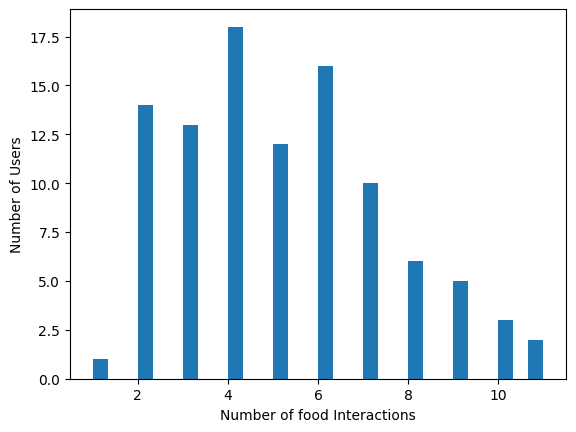

In [48]:
# historgram to check the the how many interactions with food of each user 
interactions = food.groupby('User_ID').count()['Food_ID']
plt.hist(interactions, bins=30)

plt.xlabel('Number of food Interactions')
plt.ylabel('Number of Users')

plt.show()

- Less user interaction with the high number of foods and high user interaction with the less number of foods

## Creating User Item Matrix

### Finding same combination duplicates


In [49]:
# Check for duplicate combinations of 'User_ID' and 'Food_ID'
duplicate_combinations = food.duplicated(subset=['User_ID', 'Food_ID'], keep=False)

# Filter the dataset to show only the duplicate combinations
duplicate_entries = food[duplicate_combinations]

# Print the duplicate entries
print(duplicate_entries)


     User_ID  Food_ID  Rating
76        15       29       7
83        15       29       9
311       59       43       7
312       59       43       3
414       80       49       8
418       80       49       9


In [55]:
food.drop(duplicate_entries.index, inplace=True)
food.head()


,User_ID,Food_ID,Rating
0,1,88,4
1,1,46,3
2,1,24,5
3,1,25,4
4,2,49,1


In [56]:
interactions_matrix = food.pivot(index='User_ID',columns='Food_ID',values ='Rating')

In [57]:
interactions_matrix.shape

(100, 309)

In [59]:
interactions_matrix.head()

Food_ID,1,2,3,4,5,6,7,8,9,10,...,300,301,302,303,304,305,306,307,308,309
User_ID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
interactions_matrix = interactions_matrix.fillna(0)

# Finding Similar User

In [69]:
# Similarity between the user based on the user food item interaction matrix
from sklearn.metrics.pairwise import cosine_similarity

def similar_user(User_ID, interactions_matrix):
    similarity = []
    for user in range (1,interactions_matrix.shape[0]+1):
        sim = cosine_similarity([interactions_matrix.loc[User_ID]],[interactions_matrix.loc[user]])
        similarity.append((user,sim))

    # sort by similarity

    similarity.sort(key=lambda x:x[1], reverse =True)

    # Create list of just the user ids

    most_similar_user = [tup[0]for tup in similarity]

    #create list similarity score 

    similarity_score = [tup[1] for tup in similarity]

    # remove the users own ids

    most_similar_user.remove (User_ID)

    #remove the user's own similarity score
    similarity_score.remove(similarity_score[0])

    return most_similar_user, similarity_score


In [70]:
similar_user(100, interactions_matrix)[0][:5]

[1, 87, 86, 2, 3]

In [71]:
similar_user(100, interactions_matrix)[1][:5]

[array([[0.39003031]]),
 array([[0.09680298]]),
 array([[0.05536874]]),
 array([[0.]]),
 array([[0.]])]

## Creating Similarity based colloborative recommnedation system

In [72]:
def recommendations(User_ID, num_of_foods, user_item_interactions):
    #find the most similar user to the user_id for which we want to recommend foods
    most_similar_user = similar_user(User_ID, user_item_interactions)[0]

    #find out those foods which this user has already interacted with
    food_ids = set (list(interactions_matrix.columns[np.where(interactions_matrix.loc[User_ID]>0)]))
    
    # create an empty list to store the recommended movies
    recommendations = []
    
    # copy those movies which are already interacted by user_id
    already_interacted = food_ids.copy()
   
    # loop through each similar user from the list of most_similar_users
    for similar_user in most_similar_user :
    
    # implement the below code till the length of recommended movies does not become equal to num_of_movies
       
        if len(recommendations) < num_of_foods:
           
            # store all the movies interacted by each similar user to user_id
            similar_user_food_ids =set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
           
            # add those movies in the recommended list which are present in similar_user_movie_ids but not present in already_interacted
            recommendations.extend(list(similar_user_food_ids.difference(already_interacted)))
           
            # now add all those movies into already_interacted which we already added in recommendations
            already_interacted = already_interacted.union(similar_user_food_ids)

        else:
            break
        
    return recommendations[:num_of_foods]

In [74]:
# Check the function
recommendations (8 , 5 ,interactions_matrix)

UnboundLocalError: local variable 'similar_user' referenced before assignment

In [68]:
food['Food_ID'].value_counts()[:3]

Food_ID
163    7
5      6
23     6
Name: count, dtype: int64